In [29]:
# import numerical functions, plotting functions and statistical functions
import numpy as np
# !pip install pip
# !pip install --upgrade pip
# !pip install scipy
import scipy as sp
import scipy.stats
import pandas as pd
import json
from sklearn.preprocessing import RobustScaler

# !pip install pystan
import stan
# !pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

# !pip install arviz
import arviz

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [ ]:
# !pip uninstall numba
# !pip install --upgrade numba

In [2]:
def diagnose(name):
    if 'disease' in name:
        return 1
    else:
        return 0

In [3]:
raw_df = pd.read_csv('./data/kidney_countdata.txt', sep='\t', quotechar='"')
raw_df.rename(columns={'Unnamed: 0': 'gene'}, inplace=True)

meta_df = pd.read_csv('./data/kidney_metadata.txt', sep='\t', quotechar='"')
meta_df.rename(columns={'Unnamed: 0': 'ROI'}, inplace=True)
meta_df['diagnosis'] = meta_df['slide name'].map(diagnose)

### Data Summary


In [ ]:
print(f"Number of genes: {raw_df.shape[0]}")
print(f"Number of ROIs: {len(meta_df['ROI'].unique())}")
print("Diagnosis counts:")
print(meta_df['diagnosis'].value_counts())
print(f"ROIs per individual")
print(meta_df['slide name'].value_counts())

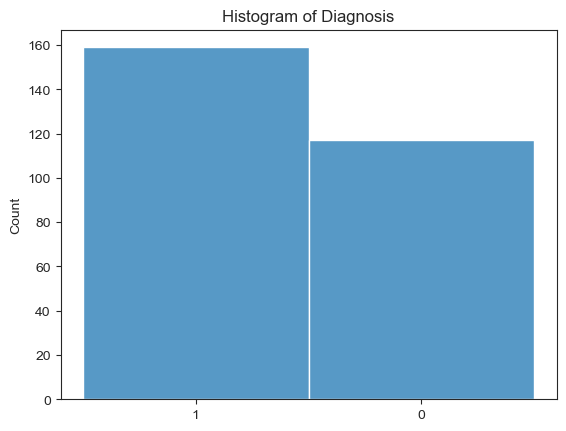

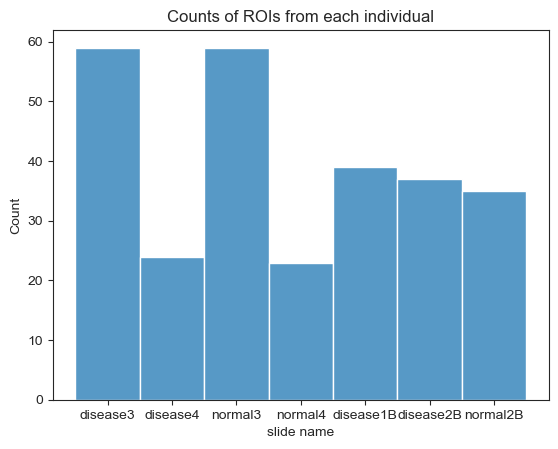

In [22]:

sns.histplot([str(x) for x in meta_df['diagnosis'].values])
plt.title('Histogram of Diagnosis')
plt.show()

sns.histplot(meta_df['slide name'])
plt.title('Counts of ROIs from each individual')
plt.show()

/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_24241/3247660967.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means = raw_df.mean(axis=0)


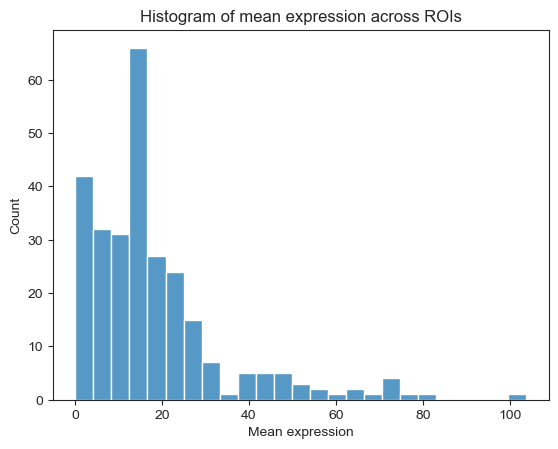

/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/ipykernel_24241/3247660967.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stds = raw_df.std(axis=0)


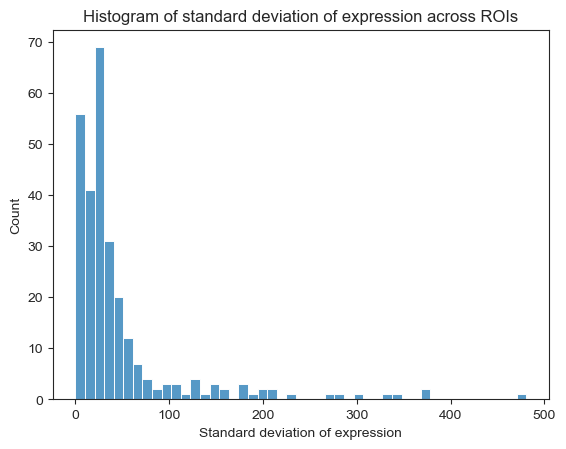

In [27]:
means = raw_df.mean(axis=0)
sns.histplot(means)
plt.title('Histogram of mean expression across ROIs')
plt.xlabel('Mean expression')
plt.show()

stds = raw_df.std(axis=0)
sns.histplot(stds)
plt.title('Histogram of standard deviation of expression across ROIs')
plt.xlabel('Standard deviation of expression')
plt.show()

In [37]:
def prepare_and_save_data(test_individuals=['disease2B', 'normal2B'], normalization='z-score'):
    # Option 0: Remove test subjects from the data
    if len(test_individuals) > 0:
        test_ROIs = meta_df[meta_df['slide name'].isin(test_individuals)]['ROI'].values
        suffix = '_indv'
    # Option 2: randomly sample 20 ROIs from each class to be the test set
    else:
        d_vals = meta_df[meta_df['diagnosis'] == 1]['ROI'].values
        d_vals = np.random.permutation(d_vals)
        d_vals = d_vals[:20]
        n_vals = meta_df[meta_df['diagnosis'] == 0]['ROI'].values
        n_vals = np.random.permutation(n_vals)
        n_vals = n_vals[:20]
        test_ROIs = np.concatenate((d_vals, n_vals))
        suffix = '_random_20'
    
    df = raw_df
    column_list = [col for col in df.columns if col != 'gene' and sum(df[col]) > 0 and col not in test_ROIs]
    test_column_list = [col for col in df.columns if col != 'gene' and sum(df[col]) > 0 and col in test_ROIs]

    # # Option 1: normalize by sum of all counts for an ROI, multiplied by 1,000 to prevent underflow
    if normalization == 'sum':
        X = [(df[col]*1000/sum(df[col])).tolist() for col in column_list]
        test_X = [(df[col]*1000/sum(df[col])).tolist() for col in test_column_list]
    # Option 2: normalize using z-score method:
    elif normalization == 'z-score':
        X = [sp.stats.zscore(df[col]).tolist() for col in column_list]
        test_X = [sp.stats.zscore(df[col]).tolist() for col in test_column_list]
    # # Option 3: normalize using min-max method:
    elif normalization == 'min-max':
        X = [((df[col]-min(df[col]))/(max(df[col])-min(df[col]))).tolist() for col in column_list]
        test_X = [((df[col]-min(df[col]))/(max(df[col])-min(df[col]))).tolist() for col in test_column_list]
    # # Option 4: normalize using quantile method:
    elif normalization == 'quantile':
        X = []
        test_X = []
        for col in column_list:
            rs = RobustScaler()
            scaled = rs.fit_transform(df[col].values.reshape(-1, 1))
            X.append(scaled.tolist())

        for col in test_column_list:
            rs = RobustScaler()
            scaled = rs.fit_transform(df[col].values.reshape(-1, 1))
            test_X.append(scaled.tolist())
    else:
        raise ValueError('Invalid normalization method')

    Y = []
    for col in column_list:
        Y.append(int(meta_df[meta_df['ROI']==col]['diagnosis'].values[0]))

    test_Y = []
    for col in test_column_list:
        test_Y.append(int(meta_df[meta_df['ROI']==col]['diagnosis'].values[0]))

    data = {'N': len(X), 'q': len(df), 'X': X, 'Y': Y}

    with open(f"/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/genes/model_norm/model_norm{suffix}.data.json", "w") as f:
        json.dump(data, f)
    
    return data, test_X, test_Y


In [38]:
data_indv, test_X_indv, test_Y_indv = prepare_and_save_data(test_individuals=['disease2B', 'normal2B'], normalization='z-score')
data_rand, test_X_rand, test_Y_rand = prepare_and_save_data(test_individuals=[], normalization='z-score')

204
204


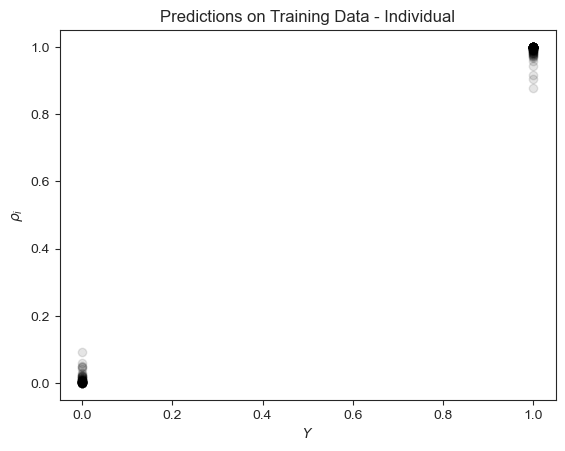

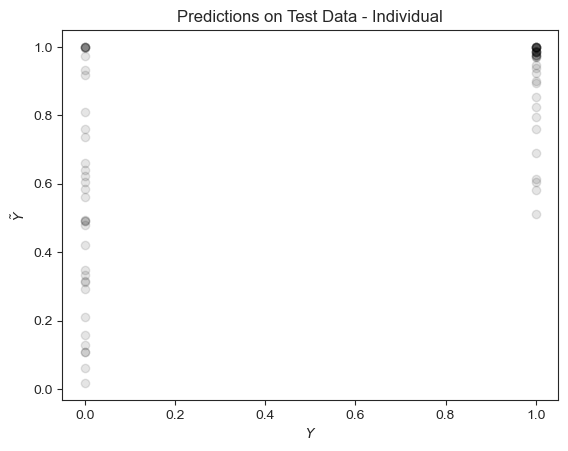

        P(Y)  accuracy  samples
Y                              
0  19.570540        17       35
1  33.570994        37       37
236
236


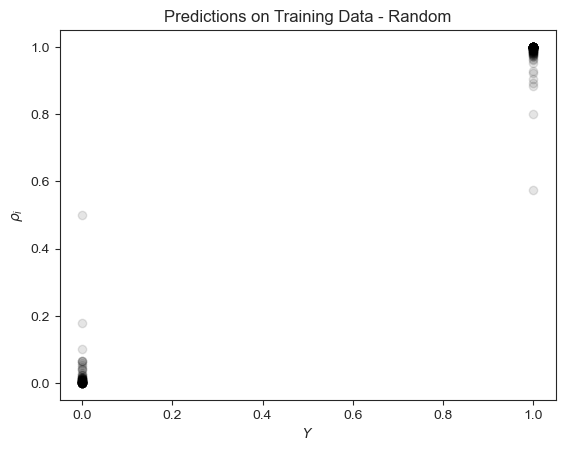

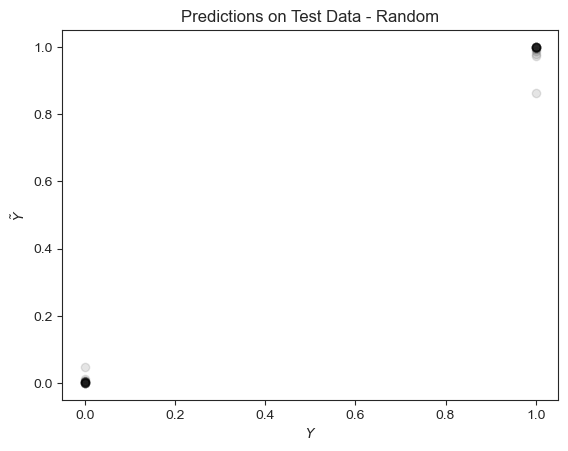

        P(Y)  accuracy  samples
Y                              
0   0.101771        20       20
1  19.781703        20       20


In [52]:
def visualize_results(data, test_X, test_Y, suffix='_indv', plot_suffix=''):
    t_out = pd.read_csv(f"/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/output{suffix}.csv",
                        comment='#')
    t_betas = [t_out[col][0] for col in t_out.columns if 'beta' in col]

    scaled = [np.array(t_betas) * x[:] for x in data['X']]
    z = [t_out['alpha'][0] + sum(s) for s in scaled]
    Y_tilde = np.exp(z) / (1 + np.exp(z))
    print(len(data['Y']))
    print(len(Y_tilde))
    plt.scatter(data['Y'], Y_tilde, color='k', alpha=0.1, zorder=-10)
    plt.ylabel(r'$\rho_i$')
    plt.xlabel(r'$Y$')
    plt.title(f"Predictions on Training Data{plot_suffix}")
    plt.show()

    scaled = [np.array(t_betas) * x[:] for x in test_X]
    z = [t_out['alpha'][0] + sum(s) for s in scaled]
    Y_tilde = np.exp(z) / (1 + np.exp(z))
    plt.scatter(test_Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
    plt.ylabel(r'$\tilde{Y}$')
    plt.xlabel(r'$Y$')
    # plt.yscale('log')
    plt.title(f"Predictions on Test Data{plot_suffix}")
    plt.show()

    accuracy = []
    for i in range(len(Y_tilde)):
        if Y_tilde[i] > 0.5:
            accuracy.append(1 if test_Y[i] == 1 else 0)
        else:
            accuracy.append(1 if test_Y[i] == 0 else 0)
    summary_table = pd.DataFrame({'Y': test_Y, 'P(Y)': Y_tilde, 'accuracy': accuracy, 'samples': 1})
    s_g = summary_table.groupby('Y').sum()
    print(s_g)

visualize_results(data_indv, test_X_indv, test_Y_indv, suffix='_indv', plot_suffix=' - Individual')
visualize_results(data_rand, test_X_rand, test_Y_rand, suffix='_random_20', plot_suffix=' - Random')

We develop a multinomial model where the health status (Normal or Diseased) associated with a sample $m$ is the dependent variable $Y_m\in\{0,1\}$ and the independent variable $X^m$ is the gene expression of the sample. We will model a score $Z=\beta\cdot X$, which can be converted into a probability of $Y_m$ given $(X^m,\beta)$. In our initial implementation, we model the $\beta$ values as being drawn from a normal distribution. Our model is therefore:
$$Y\in\{0, 1\}$$
$$Y^i\sim\text{Bernoulli}\left(\rho_i\right)$$
$$Z_i=\sum_j x_j^i\beta_j$$
$$\rho_i=\text{logit}\left(Z_i\right)$$
$$\beta_j\sim Normal\left(0,\sigma\right)$$
$$\sigma=1$$

In [ ]:
# Note: below is based on Week 9 colab: https://colab.research.google.com/drive/1itBoJq9kUBVrEAkWWnsWtMB9RSrx1tt4?usp=sharing#scrollTo=abZBuL6lH-BL
model_code = """
data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha;
    vector[q] beta;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = alpha;
        for (j in 1:q)
        {
            z[i] += beta[j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
    alpha ~ normal(0, 1);
    beta ~ normal(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

In [ ]:
# Note: below is based on Week 9 colab: https://colab.research.google.com/drive/1itBoJq9kUBVrEAkWWnsWtMB9RSrx1tt4?usp=sharing#scrollTo=abZBuL6lH-BL
model_laplace = """
data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha;
    vector[q] beta;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = alpha;
        for (j in 1:q)
        {
            z[i] += beta[j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
    alpha ~ double_exponential(0, 1);
    beta ~ double_exponential(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

In [ ]:
model_laplace_mix = """
data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha_beta;
    real alpha_gamma;
    vector[q] beta;
    vector[q] gamma;
    real<lower=0,upper=1> pi;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = pi * alpha_beta + (1-pi) * alpha_gamma;
        for (j in 1:q)
        {
            z[i] += pi * beta[j] * X[i, j] + (1-pi) * gamma[j] * X[i, j];
        }
    }
}
model {
    alpha_beta ~ double_exponential(0, 1);
    alpha_gamma
    pi ~ beta(1, 1);
    beta ~ double_exponential(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

In [ ]:
model = stan.build(model_laplace, data={'N': len(X), 'q': len(df), 'X': X, 'Y': Y})

In [ ]:
fit = model.sample(num_chains=4, num_samples=1000)

In [ ]:
fit_az = arviz.from_pystan(fit)
arviz.summary(fit_az)

In [ ]:
s_X = X[0]
s_X.sort()
print(max(s_X))
sns.histplot(s_X)

In [ ]:
# p_betas = [np.mean(x) for x in fit['beta']]
# sns.histplot(p_betas, label='sampled')
# sns.histplot(t_betas, label='optimized')
# plt.show()

plt.bar(np.abs(t_betas), label='optimized', bins=100)

In [ ]:
az.plot_trace(fit_simple_az, var_names=['alpha', 'beta', 'sigma']);
plt.tight_layout()

In [ ]:
# any diverging transitions?
print("Number of diverging samples: {}".format(fit['divergent__'].sum()))

In [ ]:
print(len(fit['beta']))

In [ ]:
# posterior of z
plt.figure(figsize=(4, 4))
sns.kdeplot(fit['beta'][:])
plt.xlabel(r"$\beta$")
plt.ylabel("Posterior density")
sns.despine()
plt.legend()

In [ ]:
# viz_scatter()
from sklearn.metrics import confusion_matrix
import random

correct_guesses = 0
total_guesses = 0
# add simulated data points
for i in range(10):
    idx = np.random.randint(0, 4000)
    scaled = [fit['beta'][:, idx] * x[:] for x in X]
    z = [fit['alpha'][0, idx] + sum(s) for s in scaled]
    Y_tilde = np.exp(z) / (1 + np.exp(z))
    plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
#     r = [random.random() for _ in range(len(Y_tilde))]
#     correct_guesses += len(r[r < Y_tilde])
#     total_guesses += len(r)

# print(correct_guesses / total_guesses)

plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# sns.despine()

In [8]:
correct_guesses = 0
total_guesses = 0
# add simulated data points

scaled = [np.array(t_betas) * x[:] for x in X]
z = [t_out['alpha'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

plt.show()

ValueError: operands could not be broadcast together with shapes (18643,) (18642,) 

In [ ]:
correct_guesses = 0
total_guesses = 0
# add simulated data points
sns.scatterplot(x=[i for i in range(len(t_betas))], y=t_betas)
plt.show()

scaled = [np.array(t_betas) * x[:] for x in test_X]
z = [t_out['alpha'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(test_Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Test Data')
plt.show()

z.sort()
plt.scatter(z, np.exp(z) / (1 + np.exp(z)))
plt.xlabel('z')
plt.ylabel(r'$\tilde{Y}$')

accuracy = []
for i in range(len(Y_tilde)):
    if Y_tilde[i] > 0.5:
        accuracy.append(1 if test_Y[i] == 1 else 0)
    else:
        accuracy.append(1 if test_Y[i] == 0 else 0)
summary_table = pd.DataFrame({'ROI': test_column_list, 'Y': test_Y, 'P(Y)': Y_tilde, 'accuracy': accuracy, 'samples': 1})
print(summary_table)
s_g = summary_table.groupby('Y').sum()
print(s_g)

In [ ]:
X_to_use = np.array(X)
X_to_use = [x[abs_betas > 0.01] for x in X_to_use]
test_X_to_use = np.array(test_X)
test_X_to_use = [x[abs_betas > 0.01] for x in test_X_to_use]
scaled = [np.array(t_betas_to_use) * x[:] for x in X_to_use]
z = [t_out['alpha'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

print(Y)
print(Y_tilde)
plt.show()

From https://www.cs.bham.ac.uk/~axk/laplace.pdf,
$$_t=\frac{\sum_n(y_n-\sum_{t'\neq t}w_{t'}x_{t'n})x_{tn}}{\sum_n x^2_{tn}}$$


### Evaluating the Laplace mixture model

In [16]:
t_out = pd.read_csv("/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/output.csv",
                    comment='#')
print(t_out.head())
t_alpha_beta = t_out['alpha_beta'][0]
t_alpha_gamma = t_out['alpha_gamma'][0]
pi = t_out['pi'][0]
print(pi)
t_betas = [t_out[col][0] for col in t_out.columns if 'beta.' in col]
t_gammas = [t_out[col][0] for col in t_out.columns if 'gamma.' in col]
print(sum(t_betas))
print(sum(t_gammas))
abs_betas = np.abs(t_betas)
np_betas = np.array(t_betas)
# genes_to_use = df[abs_betas > 0.01]['gene']
# t_betas_to_use = np_betas[abs_betas > 0.01]

      lp__    alpha_beta   alpha_gamma    beta.1        beta.2        beta.3  \
0 -16.3899 -1.834920e-11  1.446180e-11 -0.022265 -1.930490e-11 -2.185890e-07   

         beta.4    beta.5        beta.6        beta.7  ...    z.195    z.196  \
0  1.572330e-11 -0.000472 -3.895300e-11  2.014980e-11  ...  8.84526  5.92375   

     z.197   z.198    z.199    z.200    z.201    z.202   z.203    z.204  
0  8.22191  4.3373  7.17735  7.82966  3.55517  2.79929  7.3715  6.81289  

[1 rows x 37492 columns]
0.495743
0.24955322907539992
0.2521605816745162


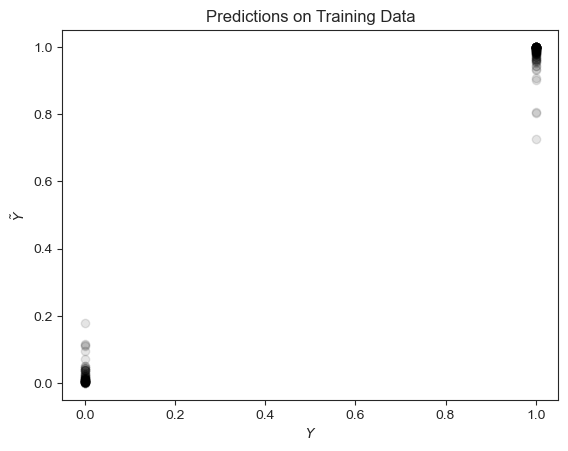

In [18]:
### Laplace Mix Model - training data

scaled = [pi * np.array(t_betas) * x[:] + (1-pi) * np.array(t_gammas) * x[:] for x in X]
z = [t_out['alpha_beta'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

plt.show()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0.74289157 0.98316844 0.58595448 0.80595028 0.96789754 0.82968222
 0.92271387 0.4347685  0.72481079 0.66233439 0.96983206 0.96552655
 0.59675688 0.95673348 0.9973581  0.95342808 0.99192665 0.60349905
 0.9957578  0.99888855 0.99673263 0.92575629 0.99789261 0.99976708
 0.99808582 0.97491332 0.96352909 0.86968776 0.97395159 0.80201317
 0.91609547 0.97951581 0.99744881 0.97694351 0.88827

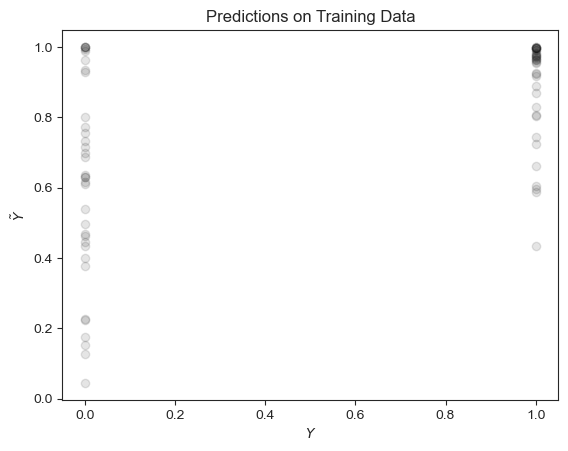

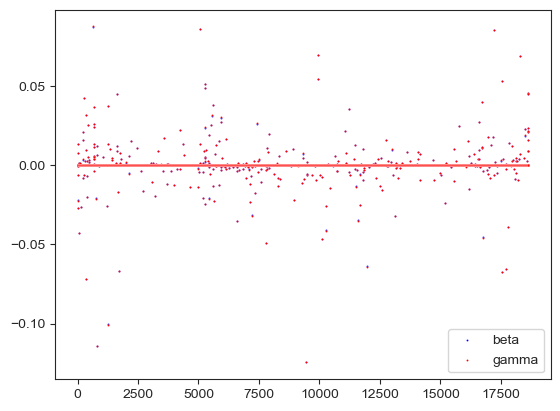

                            ROI  Y      P(Y)  accuracy  samples
0   DSP-1001250007868-B-A12.dcc  1  0.742892         1        1
1   DSP-1001250007868-B-B01.dcc  1  0.983168         1        1
2   DSP-1001250007868-B-B02.dcc  1  0.585954         1        1
3   DSP-1001250007868-B-B03.dcc  1  0.805950         1        1
4   DSP-1001250007868-B-B04.dcc  1  0.967898         1        1
..                          ... ..       ...       ...      ...
67  DSP-1002510007866-C-F03.dcc  0  0.461424         1        1
68  DSP-1002510007866-C-F04.dcc  0  0.467404         1        1
69  DSP-1002510007866-C-F05.dcc  0  0.631153         0        1
70  DSP-1002510007866-C-F06.dcc  0  0.963235         0        1
71  DSP-1002510007866-C-F07.dcc  0  0.377536         1        1

[72 rows x 5 columns]
        P(Y)  accuracy  samples
Y                              
0  21.651199        13       35
1  32.904500        36       37


In [21]:
scaled = [pi * np.array(t_betas) * x[:] + (1-pi) * np.array(t_gammas) * x[:] for x in test_X]
z = [t_out['alpha_beta'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(test_Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

print(Y)
print(Y_tilde)
plt.show()

sns.scatterplot(x=[i for i in range(len(t_betas))], y=t_betas, c='b', s=2, label='beta')
sns.scatterplot(x=[i for i in range(len(t_gammas))], y=t_gammas, c='r', s=2, label='gamma')
plt.show()

accuracy = []
for i in range(len(Y_tilde)):
    if Y_tilde[i] > 0.5:
        accuracy.append(1 if test_Y[i] == 1 else 0)
    else:
        accuracy.append(1 if test_Y[i] == 0 else 0)
summary_table = pd.DataFrame({'ROI': test_column_list, 'Y': test_Y, 'P(Y)': Y_tilde, 'accuracy': accuracy, 'samples': 1})
print(summary_table)
s_g = summary_table.groupby('Y').sum()
print(s_g)